In [1]:
from scipy.optimize import minimize,LinearConstraint,Bounds
import numpy as np
import numdifftools as nd

from scipy.optimize import linprog
import time

def min_fun(x):
    return (x[0]-1)**2 + (x[1]-4)**2


class frank_wolfe():

    def __init__(self, min_fun, A, b, bounds, x0, iterations=100):
        self.min_fun = min_fun
        self.A = A
        self.b = b
        self.bounds = bounds
        self.x0 = x0
        self.iterations = iterations
        self.x_min = []
        self.f_min = 0
        self.x_t = []
        self.s_t = []
        self.f_t = []
        self.violation = 0
        self.time = 0

    def __repr__(self):
        out = 'f_min: ' + str(self.f_min) + '\n' + \
              'x_min: ' + str(self.x_min) + '\n' + \
              'violation: ' + str(self.violation) + '\n' + \
              'time: ' + str(self.time)
        return out

    def optimize(self):
        x = self.x0
        t1 = time.time()
        for i in range(0, self.iterations):
            gamma = 2 / (i + 2)
            grad_def = nd.Gradient(self.min_fun)
            grad = grad_def(x)
            update = linprog(grad, A_ub=self.A, b_ub=self.b, A_eq=None, b_eq=None, bounds=self.bounds,
                             method='interior-point', callback=None, x0=None,
                             options={'sym_pos': False, 'lstsq': True})

            s = update.x
            self.s_t.append(s)
            x = x + gamma * (s - x)
            self.f_t.append(self.min_fun(x))
            self.x_t.append(x)
        t2 = time.time()
        self.time = t2 - t1

        constraints = np.dot(self.A, x) - self.b
        self.violation = np.sum([i for i in constraints if i > 0])
        self.x_min = x
        self.f_min = self.f_t[-1]
        return self

constr_num = 2
var_num = 3

A = np.random.randint(-10,10, (constr_num,var_num))
ub = 10*np.ones(constr_num)

bounds=[(0,10) for i in range(0,var_num)]
x0 = np.random.randint(0,10,(var_num))


iterations = 200
fw = frank_wolfe(min_fun,A,ub,bounds,x0,iterations)
results = fw.optimize()


bounds = Bounds(np.zeros(var_num), 10*np.ones(var_num))
lb = -np.inf*np.ones(constr_num)
linear_constraint = LinearConstraint(A, lb, ub)

res = minimize(min_fun, x0, method='trust-constr', jac=nd.Gradient(min_fun),
                constraints=linear_constraint, bounds=bounds,
                options={'verbose': 0,'gtol': 1e-8, 'disp': True})

f_star = [res.fun for i in range(0,len(results.f_t))]

`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 23, CG iterations: 44, optimality: 3.65e-09, constraint violation: 0.00e+00, execution time: 0.12 s.


In [9]:


import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plot
from matplotlib.ticker import MaxNLocator
from itertools import product
from warnings import warn
from sklearn.datasets import make_spd_matrix


# In[9]:


def WolfeLineSearch(f, f_grad, xk, pk, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    Parameters
    ----------
    f : callable f(x)
        Objective function.
    f_grad : callable f'(x)
        Objective function gradient.
    xk : ndarray
        Starting point.
    pk : ndarray
        Search direction.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha : float or None
        Alpha for which ``x_new = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    phi : float or None
        New function value ``f(x_new)=f(x0+alpha*pk)``,
        or None if the line search algorithm did not converge.
    """

    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)

    alpha_star, phi_star, derphi_star = WolfeLineSearch2(phi, derphi, c1, c2, amax, maxiter)

    if derphi_star is None:
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star


def WolfeLineSearch2(phi, derphi, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    alpha > 0 is assumed to be a descent direction.
    Parameters
    ----------
    phi : callable phi(alpha)
        Objective scalar function.
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size.
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha_star : float or None
        Best alpha, or None if the line search algorithm did not converge.
    phi_star : float
        phi at alpha_star.
    derphi_star : float or None
        derphi at alpha_star, or None if the line search algorithm
        did not converge.
    """
    
    phi0 = phi(0.)
    derphi0 = derphi(0.)

    alpha0 = 0
    alpha1 = 1.0

    if amax is not None:
        alpha1 = min(alpha1, amax)

    phi_a1 = phi(alpha1)
    #derphi_a1 = derphi(alpha1) evaluated below

    phi_a0 = phi0
    derphi_a0 = derphi0

    for i in range(maxiter):
        if alpha1 == 0 or (amax is not None and alpha0 == amax):
            # alpha1 == 0: This shouldn't happen. Perhaps the increment has
            # slipped below machine precision?
            alpha_star = None
            phi_star = phi0
            derphi_star = None

            if alpha1 == 0:
                msg = 'Rounding errors prevent the line search from converging'
            else:
                msg = "The line search algorithm could not find a solution " +                       "less than or equal to amax: %s" % amax

            warn(msg, RuntimeWarning)
            break

        if (phi_a1 > phi0 + c1 * alpha1 * derphi0) or            ((phi_a1 >= phi_a0) and (i > 1)):
            alpha_star, phi_star, derphi_star =                         _zoom(alpha0, alpha1, phi_a0,
                              phi_a1, derphi_a0, phi, derphi,
                              phi0, derphi0, c1, c2)
            break

        derphi_a1 = derphi(alpha1)
        if (abs(derphi_a1) <= -c2*derphi0):
            alpha_star = alpha1
            phi_star = phi_a1
            derphi_star = derphi_a1
            break

        if (derphi_a1 >= 0):
            alpha_star, phi_star, derphi_star =                         _zoom(alpha1, alpha0, phi_a1,
                              phi_a0, derphi_a1, phi, derphi,
                              phi0, derphi0, c1, c2)
            break

        alpha2 = 2 * alpha1  # increase by factor of two on each iteration
        if amax is not None:
            alpha2 = min(alpha2, amax)
        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi(alpha1)
        derphi_a0 = derphi_a1

    else:
        # stopping test maxiter reached
        alpha_star = alpha1
        phi_star = phi_a1
        derphi_star = None
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star, derphi_star


def _cubicmin(a, fa, fpa, b, fb, c, fc):
    """
    Finds the minimizer for a cubic polynomial that goes through the
    points (a,fa), (b,fb), and (c,fc) with derivative at a of fpa.
    If no minimizer can be found, return None.
    """
    # f(x) = A *(x-a)^3 + B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db,
                                            fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _quadmin(a, fa, fpa, b, fb):
    """
    Finds the minimizer for a quadratic polynomial that goes through
    the points (a,fa), (b,fb) with derivative at a of fpa.
    """
    # f(x) = B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fa
            C = fpa
            db = b - a * 1.0
            B = (fb - D - C * db) / (db * db)
            xmin = a - C / (2.0 * B)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo,
          phi, derphi, phi0, derphi0, c1, c2):
    """
    Zoom stage of approximate linesearch satisfying strong Wolfe conditions.
    """

    maxiter = 10
    i = 0
    delta1 = 0.2  # cubic interpolant check
    delta2 = 0.1  # quadratic interpolant check
    phi_rec = phi0
    a_rec = 0
    while True:
        # interpolate to find a trial step length between a_lo and
        # a_hi Need to choose interpolation here. Use cubic
        # interpolation and then if the result is within delta *
        # dalpha or outside of the interval bounded by a_lo or a_hi
        # then use quadratic interpolation, if the result is still too
        # close, then use bisection

        dalpha = a_hi - a_lo
        if dalpha < 0:
            a, b = a_hi, a_lo
        else:
            a, b = a_lo, a_hi

        # minimizer of cubic interpolant
        # (uses phi_lo, derphi_lo, phi_hi, and the most recent value of phi)
        #
        # if the result is too close to the end points (or out of the
        # interval), then use quadratic interpolation with phi_lo,
        # derphi_lo and phi_hi if the result is still too close to the
        # end points (or out of the interval) then use bisection

        if (i > 0):
            cchk = delta1 * dalpha
            a_j = _cubicmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi,
                            a_rec, phi_rec)
        if (i == 0) or (a_j is None) or (a_j > b - cchk) or (a_j < a + cchk):
            qchk = delta2 * dalpha
            a_j = _quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha

        # Check new value of a_j

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1*a_j*derphi0) or (phi_aj >= phi_lo):
            phi_rec = phi_hi
            a_rec = a_hi
            a_hi = a_j
            phi_hi = phi_aj
        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2*derphi0:
                a_star = a_j
                val_star = phi_aj
                valprime_star = derphi_aj
                break
            if derphi_aj*(a_hi - a_lo) >= 0:
                phi_rec = phi_hi
                a_rec = a_hi
                a_hi = a_lo
                phi_hi = phi_lo
            else:
                phi_rec = phi_lo
                a_rec = a_lo
            a_lo = a_j
            phi_lo = phi_aj
            derphi_lo = derphi_aj
        i += 1
        if (i > maxiter):
            # Failed to find a conforming step size
            a_star = None
            val_star = None
            valprime_star = None
            break
    return a_star, val_star, valprime_star


# In[10]:


def Griewank(xs):
    """Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    
    sigma = np.dot(xs, xs) / 4000
    pi = np.prod(cos_terms)
    return 1 + sigma - pi

def GriewankGrad(xs):
    """First derivative of Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    pi_coefs = np.prod(cos_terms) / cos_terms
    
    sigma = 2 * xs / 4000
    pi = pi_coefs * np.sin(xs / sqrts) * (1 / sqrts)
    return sigma + pi




# In[11]:


def NonlinearCG(f, f_grad, init, method='FR', c1=1e-4, c2=0.1, amax=None, tol=1e-5, max_iter=1000):
    """Non Linear Conjugate Gradient Method for optimization problem.
    Given a starting point x ∈ ℝⁿ.
    repeat
        1. Calculate step length alpha using Wolfe Line Search.
        2. Update x_new = x + alpha * p.
        3. Calculate beta using one of available methods.
        4. Update p = -f_grad(x_new) + beta * p
    until stopping criterion is satisfied.
    
    Parameters
    --------------------
        f        : function to optimize
        f_grad   : first derivative of f
        init     : initial value of x, can be set to be any numpy vector,
        method   : method to calculate beta, can be one of the followings: FR, PR, HS, DY, HZ.
        c1       : Armijo constant
        c2       : Wolfe constant
        amax     : maximum step size
        tol      : tolerance of the difference of the gradient norm to zero
        max_iter : maximum number of iterations
        
    Returns
    --------------------
        curve_x  : x in the learning path
        curve_y  : f(x) in the learning path
    """
    
    # initialize some values
    x = init
    y = f(x)
    gfk = f_grad(x)
    p = -gfk
    gfk_norm = np.linalg.norm(gfk)
    
    # for result tabulation
    num_iter = 0
    curve_x = [x]
    curve_y = [y]
    print('Initial condition: y = {:.4f}, x = {} \n'.format(y, x))
    
    # begin iteration
    while gfk_norm > tol and num_iter < max_iter:
        # search for step size alpha
        alpha, y_new = WolfeLineSearch(f, f_grad, x, p, c1=c1, c2=c2, amax=amax)
        
        # update iterate x
        x_new = x + alpha * p
        gf_new = f_grad(x_new)
        
        # calculate beta
        if method == 'FR':
            beta = np.dot(gf_new, gf_new) / np.dot(gfk, gfk)
        elif method == 'PR':
            y_hat = gf_new - gfk
            beta = np.dot(gf_new, y_hat) / np.dot(gfk, gfk)
        elif method == 'HS':
            y_hat = gf_new - gfk
            beta = np.dot(y_hat, gf_new) / np.dot(y_hat, p)
        elif method == 'DY':
            y_hat = gf_new - gfk
            beta = np.dot(gf_new, gf_new) / np.dot(y_hat, p)
        elif method == 'HZ':
            y_hat = gf_new - gfk
            beta = np.dot(y_hat, gf_new) / np.dot(y_hat, p)
            beta = beta - 2 * np.dot(y_hat, y_hat) * np.dot(p, gf_new) / (np.dot(y_hat, p) ** 2)
        else:
            raise ValueError(
                'Method is unrecognizable. Try one of the following values: FR, PR, HS, DY, HZ.'
            )
        
        # update everything
        error = y - y_new
        x = x_new
        y = y_new
        gfk = gf_new
        p = -gfk + beta * p
        gfk_norm = np.linalg.norm(gfk)
        
        # result tabulation
        num_iter += 1
        curve_x.append(x)
        curve_y.append(y)
        print('Iteration: {} \t y = {:.4f}, x = {}, gradient = {:.4f}'.
              format(num_iter, y, x, gfk_norm))
    
    # print results
    if num_iter == max_iter:
        print('\nGradient descent does not converge.')
    else:
        print('\nSolution: \t y = {:.4f}, x = {}'.format(y, x))
    
    return np.array(curve_x), np.array(curve_y)


# In[12]:


def create_mesh(Griewank):
    x = np.arange(-5, 5, 0.025)
    y = np.arange(-5, 5, 0.025)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    mesh_size = range(len(X))
    for i, j in product(mesh_size, mesh_size):
        x_coor = X[i][j]
        y_coor = Y[i][j]
        Z[i][j] = Griewank(np.array([x_coor, y_coor]))
    return X, Y, Z

def plot_contour(ax, X, Y, Z):
    ax.set(
        title='Path During Optimization Process',
        xlabel='x1',
        ylabel='x2'
    )
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, fontsize='smaller', fmt='%1.2f')
    ax.axis('square')
    return ax
    



# In[13]:


X, Y, Z = create_mesh(Griewank)
def plot_value(ax):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title='Objective Function Value During Optimization Process',
        xlabel='Iterations',
        ylabel='Objective Function Value'
    )
    ax.legend(['Wolfe line search algorithm'])
    return ax


def plot(xs, ys):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle('Gradient Descent Method')
    
    ax1 = plot_contour(ax1, X, Y, Z)
    ax1.plot(xs[:,0], xs[:,1], linestyle='--', marker='o', color='orange')
    ax1.plot(xs[-1,0], xs[-1,1], 'ro')
    
    ax2 = plot_value(ax2)
    ax2.plot(ys, linestyle='--', marker='o', color='orange')
    ax2.plot(len(ys)-1, ys[-1], 'ro')

    plt.tight_layout()
    plt.show()


# In[14]:

def fonction9():
    fig, ax= plt.subplots(figsize=(6, 6))
    X, Y, Z = create_mesh(Griewank)
    ax = plot_contour(ax, X, Y, Z)
    #ax.plot(xs[:,0], xs[:,1], linestyle='--', marker='o', color='orange')
    #ax.plot(xs[-1,0], xs[-1,1], 'ro')
    plt.show()


    # In[13]:


    X, Y, Z = create_mesh(Griewank)
    
    x0 = np.array([2, 1])
    xs, ys = NonlinearCG(Griewank, GriewankGrad, init=x0, method='PR')
    plot(xs, ys)
    
    
    

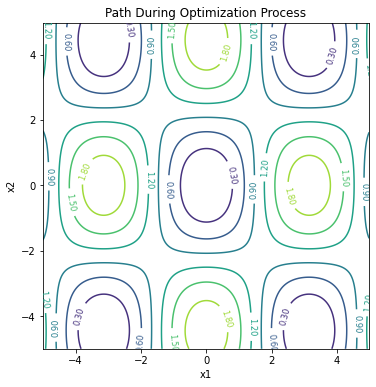

Initial condition: y = 1.3176, x = [2 1] 

Iteration: 1 	 y = 0.5170, x = [0.24349683 1.48375642], gradient = 0.6077
Iteration: 2 	 y = 0.3194, x = [-0.41339207  1.03582246], gradient = 0.5266
Iteration: 3 	 y = 0.0004, x = [-0.0111065   0.03545872], gradient = 0.0209
Iteration: 4 	 y = 0.0004, x = [-0.00716495  0.0369848 ], gradient = 0.0198
Iteration: 5 	 y = 0.0000, x = [0.00535324 0.00406989], gradient = 0.0057
Iteration: 6 	 y = 0.0000, x = [-5.84157611e-08  1.86121246e-07], gradient = 0.0000

Solution: 	 y = 0.0000, x = [-5.84157611e-08  1.86121246e-07]


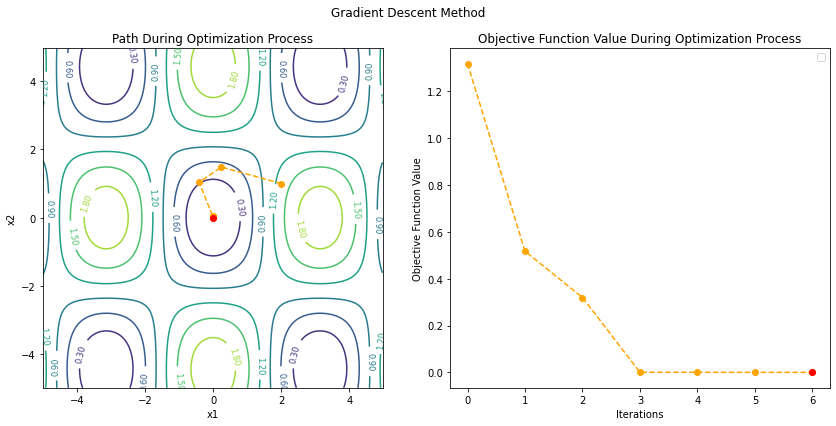

In [10]:
fonction9()

In [17]:
import numpy

#Definition de la fonction 2
def fonction3(test):
    if (test==2):
        def fct2(x):
            y = numpy.asarray(x)
            return numpy.sum(y[0]**2+y[1]**4)

        #Calcul du gradient de la fonction 2
        def fct2Gradient(x):
            y = numpy.asarray(x)
            grad = numpy.zeros_like(y)
            grad[0] = 2*y[0]
            grad[1] = 4*(y[1]**3)
            return grad
    elif(test==3):
        def fct2(x):
            y = numpy.asarray(x)
            return numpy.sum((y[0]-1)**2+100*(y[1]-y[0]**2)**2)

        #Calcul du gradient de la fonction de Rosenbrock
        def fct2Gradient(x):
            y = numpy.asarray(x)
            grad = numpy.zeros_like(y)
            grad[0] = 400*y[0]*(y[0]**2-y[1])+2*(y[0]-1)
            grad[1] = 200*(y[1]-y[0]**2)
            return grad
    x0 = numpy.array([1.1,2.1]) 
    point_error = 10**-5
    gradient_error = 10**-5


    #Appel de la fonction de calcul du gradient a pas fixe.
    Gradient_Pas_Fixe(fct2,fct2Gradient,gradient_error,point_error,x0,10**-3,10000)

#Definition de la fonction pour le calcul du gradient a pas fixe.
def Gradient_Pas_Fixe(f,f_grad,gradient_error,point_error,x0,Tolerance,NB_ITR):
    dimension = numpy.max(numpy.shape(x0))
    XArray = numpy.zeros([dimension,NB_ITR])
    fArray = numpy.zeros(NB_ITR)
    point_error_array = numpy.zeros(NB_ITR)
    gradient_error_array = numpy.zeros(NB_ITR)
    x = numpy.asarray(x0)
    xx = x
    grad = f_grad(x)
    for i in range(NB_ITR):
        x = x - Tolerance*f_grad(x)
        grad_x = f_grad(x)
        ff = f(x)
        XArray[:,i] = x
        fArray[i] = ff
        point_error_array[i] = numpy.linalg.norm(x - xx)
        gradient_error_array[i] = numpy.linalg.norm(grad)
#         if i % 100 == 0: #Affichage des rèsultas chaque 100 itération
#             print(f"Iteration={i+1}, x={x}, f(x)={f(x)}")
        if (point_error_array[i]<point_error)|(gradient_error_array[i]<gradient_error):
            break
        xx = x
    #Affichage du résultat final
    print("---------------------------------------------------------")
    print("Final Results:\n")
    print(f"x={x}\nIteration={i+1}\nf(x)={f(x)}")
    
    return {'XArray':XArray[:,0:i],'fArray':fArray[0:i],'point_error_array':point_error_array[0:i],'point_error_array':point_error_array[0:i]}







In [20]:
fonction3(2)

---------------------------------------------------------
Final Results:

x=[1.47298757e-06 1.35706677e-01]
Iteration=6755
f(x)=0.0003391601874037043


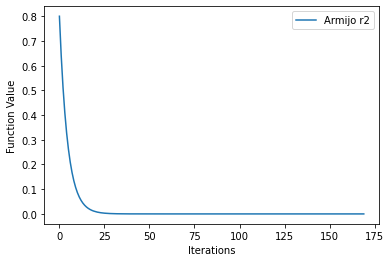


final step size : 3.351951982485684e-17  
nombre d'iteration Armijo:  171
armijo r2 : [0.8, 0.6400000000000001, 0.5120000000000001, 0.40960000000000013, 0.32768000000000014, 0.2621440000000001, 0.2097152000000001, 0.1677721600000001, 0.13421772800000006, 0.10737418240000006, 0.08589934592000005, 0.06871947673600004, 0.054975581388800036, 0.043980465111040035, 0.03518437208883203, 0.028147497671065627, 0.022517998136852502, 0.018014398509482003, 0.014411518807585602, 0.011529215046068483, 0.009223372036854787, 0.00737869762948383, 0.005902958103587064, 0.004722366482869652, 0.0037778931862957215, 0.0030223145490365774, 0.002417851639229262, 0.0019342813113834097, 0.0015474250491067279, 0.0012379400392853823, 0.0009903520314283058, 0.0007922816251426447, 0.0006338253001141158, 0.0005070602400912927, 0.00040564819207303417, 0.00032451855365842736, 0.0002596148429267419, 0.00020769187434139353, 0.00016615349947311482, 0.00013292279957849188, 0.0001063382396627935, 8.507059173023481e-05, 6

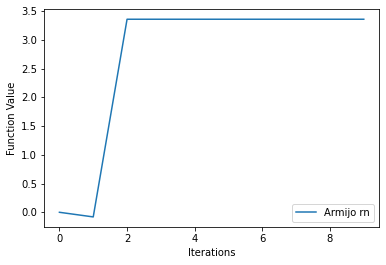

armijo rn : [0.0, -0.08056640625, 3.3569335937500004, 3.35693359375, 3.3569335937499996, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.356933593

In [29]:
#group 7
# from time import time

# import numpy as np
# from matplotlib import pyplot as plt


def armijo(max_iters=200, A=None, b=None):
    b = b if b is not None else np.matrix([[1], [2], [3], [4], [5]])
    A = A if A is not None else np.matrix([[3, -1, 0, 0, 0],
                                           [-1, 12, -1, 0, 0],
                                           [0, -1, 24, -1, 0],
                                           [0, 0, -1, 48, -1],
                                           [0, 0, 0, -1, 96]])

    n = len(b)

    def f(x):
        """
        calculate f(x) with input x
        """
        return (1 / 2 * np.dot((np.dot(x.T, A)), x) - np.dot(b.T, x)).item()

    def df(x):
        """
        calculate f'(x) with input x
        """
        return A * x + b

    def grad_desc_exact():
        """
        gradient descent with exact line minimization
        """
        x = np.matrix(np.zeros((n, 1)))
        fun_values_exact = [f(x)]
        for i in range(max_iters - 1):
            # calculate derivative
            d = df(x)
            # calculate step size
            alpha = (d.T * d / (d.T * A * d)).item()
            # update x
            x -= alpha * d
            # get new function value
            fun_values_exact.append(f(x))
            return fun_values_exact

    def grad_desc_armijo(alpha, beta=0.5, sigma=0.9):
        """
        gradient descent with Armijo step size rule
        """
        fun_values_exact = grad_desc_exact()
        x = np.matrix(np.zeros((n, 1)))
        fun_values_armijo = [f(x)]
        curr_iter = 1
        for i in range(max_iters - 1):
            # calculate derivative
            d = df(x)
            # backtracking line search
            cur_alpha = alpha
            cur_value = f(x + cur_alpha * d)
            while cur_value > f(x) + sigma * cur_alpha * d.T * d:
                cur_alpha *= beta
                cur_value = f(x + cur_alpha * d)
            # update x
            x -= cur_alpha * d
            # get new function value
            fun_values_armijo.append(cur_value)
            if cur_value == fun_values_armijo[-1]:
                curr_iter = curr_iter
            else:
                curr_iter += 1
        print('nombre d\'iteration Armijo rn ', curr_iter)
        print('solution Armijo rn ', cur_value)
        return fun_values_armijo

    results = grad_desc_armijo(alpha=1)
    plt.plot(range(10), results[:10], label='Armijo rn')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
    return results


def armijo_r2(f=None, dfx1=None, dfx2=None, t=1, count=1, x0=None, alpha=0.3, beta=0.8):
    f = f if f is not None else lambda x: ((x[0] - 1) ** 2 + (x[1] - 4) ** 2)
    dfx1 = dfx1 if dfx1 is not None else lambda x: (2 * x[0])
    dfx2 = dfx2 if dfx2 is not None else lambda x: (2 * x[1])
    x0 = x0 if x0 is not None else np.array([2, 3])

    def backtrack(x0, dfx1, dfx2, t, alpha, beta, count):
        fun_value = []
        while (f(x0) - (f(x0 - t * np.array([dfx1(x0), dfx2(x0)])) + alpha * t * np.dot(np.array([dfx1(x0), dfx2(x0)]),
                                                                                        np.array([dfx1(x0),
                                                                                                  dfx2(x0)])))) < 0:
            t *= beta
            fun_value.append(t)
            count += 1
        return t, count, fun_value

    t, count, fun_value = backtrack(x0, dfx1, dfx2, t, alpha, beta, count)
    plt.plot(range(len(fun_value)), fun_value, label='Armijo r2')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
#    print("\nfinal step size :", t, " \nnombre d'iteration Armijo: ", count)
    print("\nfinal step size :", t, " \nnombre d'iteration Armijo: ", count)

    return fun_value
#    return None


# c1 = time()
print("armijo r2 :", armijo_r2())
# print('temps de execution Armijo r2 : ', time() - c1)

# c = time()
print("armijo rn :", armijo())
# print('temps de execution Armijo : ', time() - c)





nombre d'iteration Armijo  1


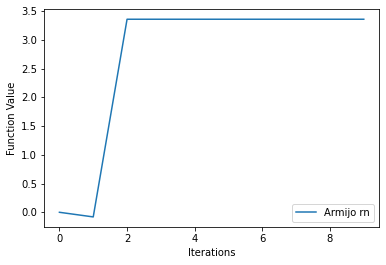

[0.0,
 -0.08056640625,
 3.3569335937500004,
 3.35693359375,
 3.3569335937499996,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499982,
 3.3569335937499

In [24]:
armijo()

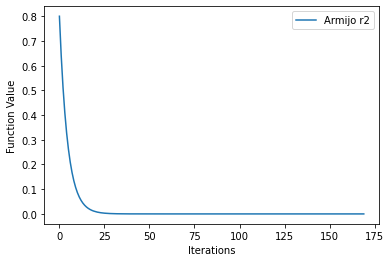


final step size armijo r2 : 3.351951982485684e-17  
nombre d'iteration Armijo r2:  171
armijo r2 : [0.8, 0.6400000000000001, 0.5120000000000001, 0.40960000000000013, 0.32768000000000014, 0.2621440000000001, 0.2097152000000001, 0.1677721600000001, 0.13421772800000006, 0.10737418240000006, 0.08589934592000005, 0.06871947673600004, 0.054975581388800036, 0.043980465111040035, 0.03518437208883203, 0.028147497671065627, 0.022517998136852502, 0.018014398509482003, 0.014411518807585602, 0.011529215046068483, 0.009223372036854787, 0.00737869762948383, 0.005902958103587064, 0.004722366482869652, 0.0037778931862957215, 0.0030223145490365774, 0.002417851639229262, 0.0019342813113834097, 0.0015474250491067279, 0.0012379400392853823, 0.0009903520314283058, 0.0007922816251426447, 0.0006338253001141158, 0.0005070602400912927, 0.00040564819207303417, 0.00032451855365842736, 0.0002596148429267419, 0.00020769187434139353, 0.00016615349947311482, 0.00013292279957849188, 0.0001063382396627935, 8.507059173

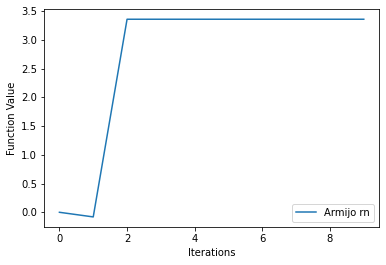

armijo rn : [0.0, -0.08056640625, 3.3569335937500004, 3.35693359375, 3.3569335937499996, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.3569335937499982, 3.356933593

In [31]:
from time import time

import numpy as np
from matplotlib import pyplot as plt


def armijo(max_iters=200, A=None, b=None):
    b = b if b is not None else np.matrix([[1], [2], [3], [4], [5]])
    A = A if A is not None else np.matrix([[3, -1, 0, 0, 0],
                                           [-1, 12, -1, 0, 0],
                                           [0, -1, 24, -1, 0],
                                           [0, 0, -1, 48, -1],
                                           [0, 0, 0, -1, 96]])
    n = len(b)

    def f(x):
        """
        calculate f(x) with input x
        """
        return (1 / 2 * np.dot((np.dot(x.T, A)), x) - np.dot(b.T, x)).item()

    def df(x):
        """
        calculate f'(x) with input x
        """
        return A * x + b

    def grad_desc_armijo(alpha, beta=0.5, sigma=0.9):
        """
        gradient descent with Armijo step size rule
        """
        x = np.matrix(np.zeros((n, 1)))
        fun_values_armijo = [f(x)]
        curr_iter = 1
        for i in range(max_iters - 1):
            # calculate derivative
            d = df(x)
            # backtracking line search
            cur_alpha = alpha
            cur_value = f(x + cur_alpha * d)
            while cur_value > f(x) + sigma * cur_alpha * d.T * d:
                cur_alpha *= beta
                cur_value = f(x + cur_alpha * d)
            # update x
            x -= cur_alpha * d
            # get new function value
            fun_values_armijo.append(cur_value)
            if cur_value == fun_values_armijo[-1]:
                curr_iter = curr_iter
            else:
                curr_iter += 1
        print('nombre d\'iteration Armijo rn ', curr_iter)
        print('solution Armijo rn ', cur_value)
        return fun_values_armijo

    results = grad_desc_armijo(alpha=1)
    plt.plot(range(10), results[:10], label='Armijo rn')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
    return results


def armijo_r2(f=None, dfx1=None, dfx2=None, t=1, count=1, x0=None, alpha=0.3, beta=0.8):
    f = f if f is not None else lambda x: ((x[0] - 1) ** 2 + (x[1] - 4) ** 2)
    dfx1 = dfx1 if dfx1 is not None else lambda x: (2 * x[0])
    dfx2 = dfx2 if dfx2 is not None else lambda x: (2 * x[1])
    x0 = x0 if x0 is not None else np.array([2, 3])

    def backtrack(x0, dfx1, dfx2, t, alpha, beta, count):
        fun_value = []
        while (f(x0) - (f(x0 - t * np.array([dfx1(x0), dfx2(x0)])) + alpha * t * np.dot(np.array([dfx1(x0), dfx2(x0)]),
                                                                                        np.array([dfx1(x0),
                                                                                                  dfx2(x0)])))) < 0:
            t *= beta
            fun_value.append(t)
            count += 1
        return t, count, fun_value

    t, count, fun_value = backtrack(x0, dfx1, dfx2, t, alpha, beta, count)
    plt.plot(range(len(fun_value)), fun_value, label='Armijo r2')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
    print("\nfinal step size armijo r2 :", t, " \nnombre d'iteration Armijo r2: ", count)
    return fun_value


c1 = time()
print("armijo r2 :", armijo_r2())
print('temps d\'execution Armijo r2 : ', time() - c1)

c = time()
print("armijo rn :", armijo())
print('temps de execution Armijo rn: ', time() - c)

In [34]:
from time import time

import numpy as np
from matplotlib import pyplot as plt


def armijo(max_iters=200, A=None, b=None):
    b = b if b is not None else np.matrix([[1], [2], [3], [4], [5]])
    A = A if A is not None else np.matrix([[3, -1, 0, 0, 0],
                                           [-1, 12, -1, 0, 0],
                                           [0, -1, 24, -1, 0],
                                           [0, 0, -1, 48, -1],
                                           [0, 0, 0, -1, 96]])
    n = len(b)

    def f(x):
        """
        calculate f(x) with input x
        """
        return (1 / 2 * np.dot((np.dot(x.T, A)), x) - np.dot(b.T, x)).item()

    def df(x):
        """
        calculate f'(x) with input x
        """
        return A * x + b

    def grad_desc_armijo(alpha, beta=0.5, sigma=0.9):
        """
        gradient descent with Armijo step size rule
        """
        x = np.matrix(np.zeros((n, 1)))
        fun_values_armijo = [f(x)]
        curr_iter = 1
        for i in range(max_iters - 1):
            # calculate derivative
            d = df(x)
            # backtracking line search
            cur_alpha = alpha
            cur_value = f(x + cur_alpha * d)
            while cur_value > f(x) + sigma * cur_alpha * d.T * d:
                cur_alpha *= beta
                cur_value = f(x + cur_alpha * d)
            # update x
            x -= cur_alpha * d
            # get new function value
            fun_values_armijo.append(cur_value)
            if cur_value == fun_values_armijo[-1]:
                curr_iter = curr_iter
            else:
                curr_iter += 1
        print('nombre d\'iteration Armijo rn ', curr_iter)
        print('solution Armijo rn ', cur_value)
        return fun_values_armijo

    results = grad_desc_armijo(alpha=1)
    plt.plot(range(10), results[:10], label='Armijo rn')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
    return None


def armijo_r2(f=None, dfx1=None, dfx2=None, t=1, count=1, x0=None, alpha=0.3, beta=0.8):
    f = f if f is not None else lambda x: ((x[0] - 1) ** 2 + (x[1] - 4) ** 2)
    dfx1 = dfx1 if dfx1 is not None else lambda x: (2 * x[0])
    dfx2 = dfx2 if dfx2 is not None else lambda x: (2 * x[1])
    x0 = x0 if x0 is not None else np.array([2, 3])

    def backtrack(x0, dfx1, dfx2, t, alpha, beta, count):
        fun_value = []
        while (f(x0) - (f(x0 - t * np.array([dfx1(x0), dfx2(x0)])) + alpha * t * np.dot(np.array([dfx1(x0), dfx2(x0)]),
                                                                                        np.array([dfx1(x0),
                                                                                                  dfx2(x0)])))) < 0:
            t *= beta
            fun_value.append(t)
            count += 1
        return t, count, fun_value

    t, count, fun_value = backtrack(x0, dfx1, dfx2, t, alpha, beta, count)
    plt.plot(range(len(fun_value)), fun_value, label='Armijo r2')
    plt.legend(loc="best")
    plt.xlabel("Iterations")
    plt.ylabel("Function Value")
    plt.show()
    print("\nfinal step size armijo r2 :", t, " \nnombre d'iteration Armijo r2: ", count)
    return None


# c1 = time()
# print("armijo r2 :", armijo_r2())
# print('temps d\'execution Armijo r2 : ', time() - c1)

# c = time()
# print("armijo rn :", armijo())
# print('temps de execution Armijo rn: ', time() - c)

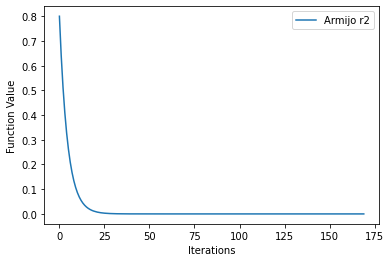


final step size armijo r2 : 3.351951982485684e-17  
nombre d'iteration Armijo r2:  171


In [36]:
armijo_r2()

In [37]:
l=[]

In [38]:
l=5*[1]

In [39]:
l

[1, 1, 1, 1, 1]

In [40]:
t=5*[1]

In [41]:
t

[1, 1, 1, 1, 1]

In [48]:
nb=int(input())
t=nb*[1]
t

3


[1, 1, 1]

In [46]:
x0=[1,1,1]
x0

[1, 1, 1]

In [45]:
import string
from sympy import *
import sys
def initForGrad(pexp, ppoint):
    """
    Cette fonction permet d'initialiser des variables necessaires au differente fonction de gradient
    le paramètre pexp est l'expression de la fonction
    le paramètre ppoint: premier point X0
    le retour: liste des variable de pexp, nombre de variable, symbole p du pas, initialisation d'un gradient correspondant à pexp, [[(var1, val1), ...,(varn, valn)]
    """
    variables = pexp.free_symbols
    return variables, len(variables), Symbol('p'), [pexp.diff(var) for var in variables], list(zip(variables, ppoint))
def Xk(pvec, ppas, pgrad, pdim, pmod=0, pcond=1):
    """
    cette fonction renvoie le point X k+1 pour une regression
    le paramètre pvec: [(var1, val1), ...,(varn, valn)] tableau qui associe au valeur de ppnt le nom de la variable à laquel
   le paramètre ppas: indique le pas necessaire pour l'iteration suivante
    le paramètre pgrad: [derivepartielEnVar1, .. , derivepartielEnVarn] gradient de la fonction d'origine
   le paramètre pdim: n dimension du vecteur de la fonction
    le retour: [val1, .. , valn] point à l'iteration k+1 soit Xk+1
    """
    if pmod == 0:
        res = [pvec[i][1] - ppas * pgrad[i].subs(pvec) for i in range(pdim)]
    elif pmod == 2:
        res = [pvec[i][1] + ppas * pgrad[i] for i in range(pdim)]
    else:
        res = [(pvec[i][1] - ppas * (pgrad[i].subs(pvec) / pcond)).evalf() for i in range(pdim)]
    return res
def expPas(ppnt, pgrad, pvec, pdim):
    """
    cette fonction renvoie l'expression de phi en fonction de p soit un vecteur de même dimension que pvec. Cette expression
    sert par la suite à calculer le pas optimal
    le paramètre ppnt: [val1, .. , valn] point à partir duquel le pas optimal
    le paramètre pgrad: [derivepartielEnVar1, .. , derivepartielEnVarn] gradient de la fonction d'origine
    le paramètre pvec: [(var1, val1), ...,(varn, valn)] tableau qui associe au valeur de ppnt le nom de la variable à laquel
    elle est associé
    le paramètre pdim: n dimension du vecteur de la fonction
    le retour: expression de phi de p
    """
    return [parse_expr(str(ppnt[i]) + " - p * " + str(pgrad[i].subs(pvec))) for i in range(pdim)]
def pasOpti(pexprpas, pvec, pp):
    """
    cette fonction permettant de calculer le pas optimal pour Xk+1
    le paramètre pexprpas: expression de f
    le paramètre pvec: vecteur trouver pour phi de p
    le paramètre pp: symbole du pas
    le retour: est le pas optimisé sinon -1 si fonction a échoué
    """
    pas = solve(pexprpas.subs(pvec), pp)  # fin calcul du pas opti
    res = -1
    for e in pas:
        if e > 0:
            res = e
            break
    return res
def gradPOpti(p_exp, ppt, tolerance):
    """
    cette fonction effectue une descente de gradient a pas optimisé
    le paramètre p_exp: expression de la fonction sur laquel effectuer une descente de gradient
    le paramètre ppt: [val1, .. , valn] point de depart de la descente de gradient
    le paramètre tolerance: de type float est le seuil à partir duquel on decidera que l'aproximation est suffisante (par rapport a la norme
    du point trouvé
    le paramètre pverbose: int par defaut à 0 et si different de 0 alors le mode verbose est activé
    le retour: [val1, .. , valn] point au plus proche du minimum local
    """
    variables, size, p, grad, vec = initForGrad(p_exp, ppt)
    expas = expPas(ppt, grad, vec, size)
    pas = pasOpti(p_exp, list(zip(variables, expas)), p)
    XK1 = Xk(vec, pas, grad, size)
    vec = list(zip(variables, XK1))
    cond = Matrix([grad[i].subs(vec) for i in range(size)]).norm()
    nombre_itter=1;
    while cond > tolerance:
        nombre_itter=nombre_itter+1
        print("X{} : {}".format( nombre_itter, XK1))
        expas = expPas(ppt, grad, vec, size)
        pas = pasOpti(p_exp, list(zip(variables, expas)), p)
        if pas == -1:
            break
        XK1 = Xk(vec, pas, grad, size)
        vec = list(zip(variables, XK1))
        cond = Matrix([grad[i].subs(vec) for i in range(size)]).norm()
    print ("Pas Optimal",pas)
    print("nombre d'ittération",nombre_itter)
    return XK1
"exemple de cours 'algo' avec resultat juste"
f = parse_expr("x**2+y**2-3*y-6*x*y")
b=0.0001
x0=[1,1]
res = gradPOpti(f, x0, float(b))
variables = f.free_symbols
vec = list(zip(variables, res))
print("point au plus proche du minimum local {}".format(f.subs(vec)))
print("approximation trouvé : {}".format(vec))

X2 : [-6, -3]
X3 : [-445/82 - 3*sqrt(373)/82, 112/41 - 15*sqrt(373)/41]
Pas Optimal -1
nombre d'ittération 3
point au plus proche du minimum local -6*(-445/82 - 3*sqrt(373)/82)*(112/41 - 15*sqrt(373)/41) + 9*sqrt(373)/82 + 1335/82 + (112/41 - 15*sqrt(373)/41)**2 + (-445/82 - 3*sqrt(373)/82)**2
approximation trouvé : [(y, -445/82 - 3*sqrt(373)/82), (x, 112/41 - 15*sqrt(373)/41)]


In [ ]:
x0=[1,1,1]